# Previsão de odds e de resultados exatos

### Introdução

O objetivo deste projeto é efetuar a previsão de resultados exatos e das odds associadas de forma precisa tendo por base o dataset fornececido.

Este dataset tem informações básicas sobre o jogo (quais os jogadores em campo, as suas posições, número de golos, cartões, posse de bola, entre outros), estatísticas da FIFA acerca dos jogadores e dados de odds provenientes de diversas casas de apostas (nomeadamente BET365, ... , ...) . 

Foi construído um modelo que permite prever o resultado exato de um jogo, isto é o número de golos da equipa da casa e da equipa de fora. Através de um segundo modelo desenvolvido, é ainda possível prever as odds para os três cenários possíveis de um determinado jogo - vitória da equipa da casa, empate ou vitória da equipa de fora.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import sqlite3
from sklearn import preprocessing
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
con = sqlite3.connect("./database.sqlite")
display_graph = False

def clean_data(data):
    #this line displays the NaN distribution before data clean up
    if display_graph:
        msno.matrix(data)
    data = data.replace("", np.NaN)
    data = data.dropna()
    if display_graph:
        msno.matrix(data)
    return data

def preprocess_data() :
    matches = pd.read_sql_query('SELECT *, strftime("%Y",date) as year, (B365H + BWH + IWH + LBH + WHH +  VCH )/6 AS home_odds, (B365D + BWD + IWD + LBD + WHD + VCD)/6 AS draw_odds,  (B365A + BWA + IWA + LBA + WHA + VCA )/6 AS away_odds FROM match',con)
    matches = matches.iloc[:, np.r_[0,2,4,7,8,9,10, 55:77, 115:119 ]]

    teams = pd.read_sql_query('SELECT team_api_id, (buildUpPlaySpeed + buildUpPlayDribbling + buildUpPlayPassing + defencePressure + defenceAggression + defenceTeamWidth)/6 as team_rating FROM team_attributes', con)
    players = pd.read_sql_query('SELECT player_api_id, strftime("%Y",date) as year, avg(potential) as player_potential, avg(overall_rating) as rating FROM player_attributes GROUP BY player_api_id, year', con)
    
    matches = clean_data(matches)
    teams = clean_data(teams)
    players = clean_data(players)
      
    result =pd.merge(matches, teams, left_on='home_team_api_id', right_on='team_api_id', how='left').drop('team_api_id', axis=1)
    result =pd.merge(result, teams, left_on='away_team_api_id', right_on='team_api_id', how='left').drop('team_api_id', axis=1)
    result.rename(columns={"team_rating_x": "home_team_rating", "team_rating_y": "away_team_rating"}, inplace=True)

    for index in range(1,12):
        player_home_id = "home_player_" + str(index)
        player_away_id = "away_player_" + str(index)
        result =pd.merge(result, players, left_on=[player_home_id, 'year'], right_on=['player_api_id', 'year'], how='left').drop(['player_api_id', player_home_id], axis=1)
        result =pd.merge(result, players, left_on=[player_away_id, 'year'], right_on=['player_api_id', 'year'], how='left').drop(['player_api_id', player_away_id], axis=1)
        result.rename(columns={"player_potential_x": player_home_id + "_potential", "player_potential_y": player_away_id + "_potential" , "rating_x": player_home_id + "_rating", "rating_y": player_away_id + "_rating"}, inplace=True)
    
    #matches = preprocessing.scale(matches)
    result = clean_data(result)
    #display(result)
    return result


In [43]:
def linear_regression(X_train, Y_train, X_test, Y_test):
    reg = LinearRegression().fit(X_train, Y_train)

    y_pred = reg.predict(X_test)
    print(r2_score(Y_test, y_pred))

    
    #plt.scatter(X_test, Y_test,  color='gray')
    plt.plot(X_test, y_pred, color='red', linewidth=2)
    plt.plot(X_test, Y_test, color='gray', linewidth=2)
    plt.show()
    #print(reg.intercept_)


    #print(reg.coef_)
    
    #reg.intercept_

  #  reg.predict(np.array([[3, 5]]))

In [10]:
def PCA_call(X, Y, dataset): 
    pca = PCA(n_components=2)
        
    #data_scaled = pd.DataFrame(preprocessing.scale(X),columns = X.columns) 

    #principalComponents = pca.fit_transform(data_scaled)
    
   # print(pca.explained_variance_ratio_)
   # print(pca.singular_values_)
    
   # print(principalComponents)
   # principalDf = pd.DataFrame(data = principalComponents
    #         , columns = ['principal component 1', 'principal component 2'])
    
    #finalDf = pd.concat([principalDf, Y], axis = 1)
#    display(finalDf)

    print (pd.DataFrame(pca.components_,columns=data_scaled.columns, index = ['PC-1','PC-2']))

In [40]:
def get_team_info(team_id, year, dataset):
    home_matches = dataset[dataset.home_team_api_id == team_id ] #('(home_team_api_id == @team_id) & (year == @year)')
    away_matches = dataset[dataset.away_team_api_id == team_id ] #('(home_team_api_id == @team_id) & (year == @year)')
    team_matches = away_matches.append(home_matches)
    team_matches = team_matches[team_matches.year == year ]
    return team_matches 

      id  league_id  stage  home_team_api_id  away_team_api_id  \
88   325          1     11              9994              9984   
89   325          1     11              9994              9984   
90   325          1     11              9994              9984   
91   325          1     11              9994              9984   
140  360          1     16              9991              9984   
141  360          1     16              9991              9984   
142  360          1     16              9991              9984   
143  360          1     16              9991              9984   
155  373          1     18             10000              9984   
156  373          1     18             10000              9984   
157  373          1     18             10000              9984   
158  373          1     18             10000              9984   
175  385          1      2              8635              9984   
176  385          1      2              8635              9984   
177  385  

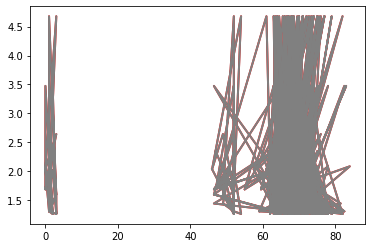

In [47]:
#def calculate_odds(match_id):
#match = pd.read_sql_query('SELECT * FROM match WHERE id = {}'.format(1), con)
dataset = preprocess_data()
#print(dataset)

team_dataset = get_team_info(9984, '2009', dataset)
print(team_dataset)

X = team_dataset.iloc[:, np.r_[5,6, 11:57]]
#X = preprocessing.scale(X)
#X = StandardScaler().fit_transform(X)

Y = team_dataset.iloc[:, 8]
#Y = preprocessing.scale(Y)
#Y = StandardScaler().fit_transform(Y)


X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size= 0.3)

linear_regression(X_train, Y_train, X_test, Y_test)
#PCA_call(X, Y, dataset)


#home_team_data = get_team_info(match.home_team_api_id, match.date)
#away_team_data = get_team_info(match.away_team_api_id, match.date)
    

***
Tema 4C, 27/05/2020

* João Alberto Preto Rodrigues Praça, up201704748@fe.up.pt 
* Liliana Natacha Nogueira de Almeida, up201706908@fe.up.pt	
* Silvia Jorge Moreira da Rocha, up201704684@fe.up.pt